In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def preprocess_seq(
    path_csv,
    feature_list=None,
    use_clinical=False,
    label_type='cpc',        # 'cpc' or 'kmeans'
    binary_labels=False,     # whether to merge cluster 2 into 1 when using kmeans
    start=6,
    end=68
):
    """
    Load and preprocess merged_all_features_clinical.csv into X, y for time-series models.

    Returns:
      X: np.ndarray of shape (n_samples, T, n_features)
      y: np.ndarray of shape (n_samples,)
      feat_cols: list of feature column names
    """
    # 1. Load CSV and drop Unnamed columns & columns with all NaNs
    df = pd.read_csv(path_csv)
    df = df.loc[:, ~df.columns.str.contains(r'^Unnamed')]
    df = df.dropna(axis=1, how='all')

    # 2. Ensure key fields
    df['hour'] = pd.to_numeric(df['hour'], errors='coerce')
    label_col = 'cpc' if label_type=='cpc' else 'cluster'
    df = df.dropna(subset=['pat_ID', 'hour', label_col])

    # 3. Handle clinical variables
    clinical_cols = ['age', 'sex', 'vfib']
    for c in clinical_cols:
        if c in df.columns:
            if df[c].dtype == object or df[c].dtype.name=='category':
                df[c] = LabelEncoder().fit_transform(df[c].astype(str))
            else:
                df[c] = pd.to_numeric(df[c], errors='coerce')
    if use_clinical:
        df[clinical_cols] = df[clinical_cols].fillna(df[clinical_cols].mean())

    # 4. Generate y
    if label_type == 'cpc':
        def _map_cpc(x):
            xs = str(x).strip().lower()
            if xs in ('good outcome','good','1','2'): return 1
            if xs in ('bad outcome','poor','3','4','5'): return 0
            try: return 1 if int(float(x)) in (1,2) else 0
            except: return np.nan
        df['y'] = df[label_col].apply(_map_cpc).astype('Int64')
        df = df.dropna(subset=['y'])
        df['y'] = df['y'].astype(int)
    else:
        df[label_col] = df[label_col].astype(int)
        if binary_labels:
            # 1) Build patient-level table: one row per pat_ID, with cpc + cluster
            pat_df = (
                df[['pat_ID', 'cpc', 'cluster']]
                .drop_duplicates(subset='pat_ID')
                .copy()
            )
            pat_df['cpc'] = pd.to_numeric(pat_df['cpc'], errors='coerce')

            # 2) Mark good outcome
            pat_df['is_good'] = pat_df['cpc'].isin([1, 2])

            # 3) Compute good ratio per cluster
            cluster_ratios = (
                pat_df
                .groupby('cluster')['is_good']
                .mean()
            )

            # 4) Identify the two clusters with lowest good ratio
            poor_clusters = cluster_ratios.nsmallest(2).index.tolist()

            # 5) Create binary label y in pat_df: poor_clusters → 0, others → 1
            pat_df['y'] = pat_df['cluster'].apply(
                lambda cl: 0 if cl in poor_clusters else 1
            )

            # 6) Merge patient-level y back to original df
            df = df.merge(
                pat_df[['pat_ID', 'y']],
                on='pat_ID',
                how='left'
            )

        else:
            # Use original cluster directly as label without merging
            df['y'] = df[label_col]

    # 5. Determine feature columns
    if feature_list is not None:
        feat_cols = feature_list.copy()
    else:
        forbidden = {'pat_ID', 'hour', 'cpc', 'cluster'}
        if not use_clinical:
            forbidden |= set(clinical_cols)
        feat_cols = [c for c in df.columns if c not in forbidden]

    # 6. Drop features that are entirely NaN
    feat_cols = [c for c in feat_cols if not df[c].isna().all()]

    # 7. Replace Inf with NaN → fill with mean → fill remaining with 0
    df[feat_cols] = df[feat_cols].replace([np.inf, -np.inf], np.nan)
    df[feat_cols] = df[feat_cols].fillna(df[feat_cols].mean())
    df[feat_cols] = df[feat_cols].apply(
        lambda col: np.nan_to_num(col, nan=0.0, posinf=0.0, neginf=0.0)
    )

    # 8. Normalize to [0,1]
    df[feat_cols] = MinMaxScaler().fit_transform(df[feat_cols])

    # 9. Assemble sequences by pat_ID + hour
    T = end - start
    X_list, y_list = [], []
    for pid, grp in df.groupby('pat_ID'):
        sub = grp[(grp['hour']>=start)&(grp['hour']<end)]
        if sub.empty:
            continue
        seq = np.zeros((T, len(feat_cols)), dtype=float)
        for _, row in sub.iterrows():
            idx = int(row['hour']) - start
            if 0 <= idx < T:
                seq[idx] = row[feat_cols].values
        X_list.append(seq)
        y_list.append(sub['y'].iloc[0])

    X = np.stack(X_list) if X_list else np.empty((0, T, len(feat_cols)))
    y = np.array(y_list, dtype=int)

    return X, y, feat_cols


In [2]:
from sklearn.utils import resample
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau

class LSTMBinary(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_layers=1, bidirectional=True, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional else 1
        # bi LSTM
        self.lstm = nn.LSTM(
            input_dim,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        # Attention 
        self.attn_proj = nn.Linear(hidden_size * self.num_directions, hidden_size * self.num_directions)
        self.attn_score = nn.Linear(hidden_size * self.num_directions, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        # Class Head
        self.fc = nn.Linear(hidden_size * self.num_directions, 1)

    def forward(self, x):
        # x: [B, T, F]
        H, _ = self.lstm(x)                       # H: [B, T, D*H]
        H = self.dropout(H)
        u = torch.tanh(self.attn_proj(H))        # u: [B, T, D*H]
        scores = self.attn_score(u).squeeze(-1)  # scores: [B, T]
        alpha = torch.softmax(scores, dim=1).unsqueeze(-1)  # alpha: [B, T, 1]
        z = torch.sum(alpha * H, dim=1)          # z: [B, D*H]
        return self.fc(z)                        #  logits

class LSTMMulti(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_size=64, num_layers=1, bidirectional=True, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional else 1
        # bi LSTM
        self.lstm = nn.LSTM(
            input_dim,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        # Attention 层
        self.attn_proj = nn.Linear(hidden_size * self.num_directions, hidden_size * self.num_directions)
        self.attn_score = nn.Linear(hidden_size * self.num_directions, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

    def forward(self, x):
        # x: [B, T, F]
        H, _ = self.lstm(x)                       # H: [B, T, D*H]
        H = self.dropout(H)

        u = torch.tanh(self.attn_proj(H))        # u: [B, T, D*H]
        scores = self.attn_score(u).squeeze(-1)  # scores: [B, T]
        alpha = torch.softmax(scores, dim=1).unsqueeze(-1)  # alpha: [B, T, 1]

        z = torch.sum(alpha * H, dim=1)          # z: [B, D*H]
        return self.fc(z)                        #  logits for CrossEntropy

        
def balance_by_duplication(X, y, target_dist='equal'):
    from collections import Counter
    classes = np.unique(y)
    counts = Counter(y)
    max_n = max(counts.values()) if target_dist == 'equal' else int(target_dist)

    X_out, y_out = [], []
    for cls in classes:
        X_cls = X[y == cls]
        n_needed = max_n - len(X_cls) if target_dist == 'equal' else max_n
        if n_needed > 0:
            X_aug = resample(X_cls, replace=True, n_samples=n_needed, random_state=42)
            X_out.append(np.concatenate([X_cls, X_aug]))
            y_out.append(np.array([cls] * (len(X_cls) + n_needed)))
        else:
            X_out.append(X_cls)
            y_out.append(np.array([cls] * len(X_cls)))
    return np.concatenate(X_out), np.concatenate(y_out)

In [3]:
# {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# ——— Load & clean ———
DATASET = "merged_all_features_clinical.csv"
df = pd.read_csv(DATASET)
df.dropna(axis=0, inplace=True)

# ——— Define feature columns ———
drop_feats = [
    'pat_ID', 'cluster', 'cpc', 'hour', 'age', 'sex', 'vfib'
]
feature_columns = [c for c in df.columns if c not in drop_feats]

# ——— Prepare X and y ———
X    = df[feature_columns].values
y_cpc = df['cpc'].values
y_km  = df['cluster'].values

# ——— Fit CPC binary classification RF with best hyperparameters ———
best_params_cpc = {
    'n_estimators':      500,
    'max_depth':         10,
    'min_samples_split': 5,
    'min_samples_leaf':  1,
}
rf_cpc = RandomForestClassifier(**best_params_cpc, random_state=42)
rf_cpc.fit(X, y_cpc)
imp_cpc = rf_cpc.feature_importances_

# ——— Fit K-means multi-class RF with best hyperparameters ———
best_params_km = {
    'n_estimators':      500,
    'max_depth':         10,
    'min_samples_split': 5,
    'min_samples_leaf':  1,
}
rf_km = RandomForestClassifier(**best_params_km, random_state=42)
rf_km.fit(X, y_km)
imp_km = rf_km.feature_importances_

# 1) Sort CPC features by importance in descending order
s_cpc = pd.Series(imp_cpc, index=feature_columns)
sorted_feats_cpc = s_cpc.sort_values(ascending=False).index.tolist()
print("CPC features sorted by importance:")
print(sorted_feats_cpc)

# 2) Sort k-means label features by importance in descending order
s_km = pd.Series(imp_km, index=feature_columns)
sorted_feats_km = s_km.sort_values(ascending=False).index.tolist()
print("\nk-means features sorted by importance:")
print(sorted_feats_km)


CPC features sorted by importance:
['meanskewamp', 'corrmean', 'overallskewamp', 'kurtavg', 'thetaalphamean', 'xcorrstd', 'ssd', 'thetaalphapct', 'avgspectkurt', 'd2MaxMaxFourAmp', 'thetakurtosis', 'd1MaxMaxFourAmp', 'betameanrat', 'alphameanrat', 'avgspectent', 'thetaalphastd', 'pctpeakpoint', 'alphakurtosis', 'stdskewamp', 'd1VarMaxFourAmp', 'thetaalphamin', 'd2VarMaxFourAmp', 'BSAR', 'deltaalphamean', 'd2VarMeanAmp', 'betakurtosis', 'BCI', 'deltastdrat', 'betaminrat', 'lv_l5', 'deltakurtosis', 'sdrms', 'alphapctrat', 'd1MeanMaxFourAmp', 'd2MeanMaxFourAmp', 'SIQ_alpha', 'd1VarMeanAmp', 'alphaminrat', 'SIQ_theta', 'thetapctrat', 'sdspectent', 'SIQ_delta', 'thetastdrat', 'sdspectkurt', 'd0MeanMaxFourAmp', 'alphastdrat', 'betapctrat', 'meanlogentropy', 'deltaalphapct', 'thetameanrat', 'deltaalphamin', 'deltathetamin', 'betastdrat', 'd1MaxAmp', 'overalliqramp', 'deltaalphastd', 'd0MaxMaxFourAmp', 'SIQ', 'deltathetamean', 'thetaminrat', 'd0MaxAmp', 'd0VarMaxAmp', 'lv_l10', 'harmmeanamp', 

In [4]:
from tqdm import tqdm

def make_model_factory(config):
    """
    Generate a model_factory function for run_task_no_cv.

    Parameters:
        config (dict): e.g. {'hidden_size': 128, 'num_layers': 2, 'bidirectional': True, 'dropout': 0.2}
    Returns:
        A model_factory function that creates LSTM models based on the provided configuration.
    """
    def model_factory(is_multiclass, F, num_classes=None):
        cls = LSTMMulti if is_multiclass else LSTMBinary
        kwargs = {
            'input_dim': F,
            'hidden_size': config['hidden_size'],
            'num_layers': config['num_layers'],
            'bidirectional': config['bidirectional'],
            'dropout': config['dropout']
        }
        if is_multiclass:
            kwargs['num_classes'] = num_classes
        return cls(**kwargs)
    
    return model_factory
    

def run_task(
    path_csv,
    features,
    task='cpc',            # 'cpc' or 'cluster'
    binary_labels=False,   # Whether to use binary labels for the cluster task
    use_clinical=False,
    start=16,
    end=68,
    epochs=50,
    batch_size=64,
    out_csv='default.csv',
    model_factory=None,
):
    # Determine label type based on task
    label_type = 'cpc' if task == 'cpc' else 'cluster'
    X_np, y_np, _ = preprocess_seq(
        path_csv,
        feature_list=features,
        use_clinical=use_clinical,
        label_type=label_type,
        binary_labels=binary_labels,
        start=start,
        end=end
    )
    X_np = np.nan_to_num(X_np)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Run on {device}")
    N, T, F = X_np.shape
    class_labels = sorted(np.unique(y_np))
    unique_labels = np.unique(y_np)
    is_multiclass = len(unique_labels) > 2
    label_dtype = torch.long if is_multiclass else torch.float32
    
    # 5-fold stratified cross-validation
    kf = StratifiedKFold(5, shuffle=True, random_state=42)
    records = []

    # Iterate over time points
    for L in tqdm(range(1, T+1), desc="Time points"):
        tp = start + L - 1
        Xw, yw = X_np[:, :L, :], y_np
        # Filter out samples with all-zero features
        mask = ~(Xw.reshape(N, -1) == 0).all(axis=1)
        Xf, yf = Xw[mask], yw[mask]

        # Skip if too few samples
        if len(yf) < 10:
            rec = {'hour': tp, 'AUC': np.nan, 'Accuracy': np.nan}
            rec.update({f'Acc_class_{lbl}': np.nan for lbl in class_labels})
            records.append(rec)
            continue

        fold_aucs, fold_accs = [], []
        per_class_acc = {lbl: [] for lbl in class_labels}

        for tr_idx, te_idx in kf.split(Xf, yf):
            X_tr_raw, y_tr_raw = Xf[tr_idx], yf[tr_idx]
            # Balance classes by duplication
            X_tr_bal, y_tr_bal = balance_by_duplication(X_tr_raw, y_tr_raw, target_dist='equal')

            train_loader = DataLoader(
                TensorDataset(torch.tensor(X_tr_bal, dtype=torch.float32),
                              torch.tensor(y_tr_bal, dtype=torch.long if is_multiclass else torch.float32)),
                batch_size=batch_size, shuffle=True)

            Xte = torch.tensor(Xf[te_idx], dtype=torch.float32).to(device)
            yte = torch.tensor(yf[te_idx], dtype=torch.long if is_multiclass else torch.float32).to(device)

            # Instantiate model
            if model_factory is not None:
                model = model_factory(
                    is_multiclass=is_multiclass,
                    F=F,
                    num_classes=len(unique_labels) if is_multiclass else None
                ).to(device)
            else:
                model = (
                    LSTMMulti(F, num_classes=len(unique_labels))
                    if is_multiclass else
                    LSTMBinary(F)
                ).to(device)

            criterion = nn.CrossEntropyLoss() if is_multiclass else nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(model.parameters(), lr=1e-3)

            # Track best metrics
            best_auc, best_acc = 0, 0
            best_y_pred = None
            
            for epoch in range(epochs):
                # Training step
                model.train()
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    logits = model(xb)
                    logits = logits.view(-1) if not is_multiclass else logits
                    loss = criterion(logits, yb)
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
            
                # Validation step
                model.eval()
                with torch.no_grad():
                    logits_te = model(Xte)
                    probs_te_epoch = (
                        torch.softmax(logits_te, dim=1).cpu().numpy() if is_multiclass
                        else torch.sigmoid(logits_te.view(-1)).cpu().numpy()
                    )
                    y_pred_epoch = (
                        np.argmax(probs_te_epoch, axis=1) if is_multiclass
                        else (probs_te_epoch >= 0.5).astype(int)
                    )
                    # Compute AUC and accuracy
                    try:
                        auc_epoch = (
                            roc_auc_score(yf[te_idx], probs_te_epoch, multi_class='ovr', average='macro')
                            if is_multiclass else roc_auc_score(yf[te_idx], probs_te_epoch)
                        )
                    except:
                        auc_epoch = 0.0
                    acc_epoch = accuracy_score(yf[te_idx], y_pred_epoch)
            
                # Update best metrics on first epoch or if improved
                if epoch == 0 or auc_epoch > best_auc:
                    best_auc = auc_epoch
                    best_acc = acc_epoch
                    best_y_pred = y_pred_epoch
            
            # Record fold metrics
            fold_aucs.append(best_auc)
            fold_accs.append(best_acc)
            cm = confusion_matrix(yf[te_idx], best_y_pred, labels=class_labels)
            for i, lbl in enumerate(class_labels):
                sup = cm[i].sum()
                if sup > 0:
                    per_class_acc[lbl].append(cm[i, i] / sup)

        # Aggregate across folds
        rec = {
            'hour': tp,
            'AUC': np.mean(fold_aucs),
            'Accuracy': np.mean(fold_accs)
        }
        rec.update({f'Acc_class_{lbl}': np.mean(per_class_acc[lbl]) for lbl in class_labels})
        records.append(rec)

    # Save and plot metrics
    df_metrics = pd.DataFrame(records)
    df_metrics.to_csv(out_csv, index=False)
    print(f"Metrics saved to {out_csv}")

    plt.figure(figsize=(8,5))
    plt.plot(df_metrics['hour'], df_metrics['AUC'], '-o', label='AUC')
    plt.plot(df_metrics['hour'], df_metrics['Accuracy'], '-s', label='Accuracy')
    for lbl in class_labels:
        plt.plot(df_metrics['hour'], df_metrics[f'Acc_class_{lbl}'], '--', label=f'Acc class {lbl}')
    plt.xlabel('Hours since ROSC')
    plt.ylabel('Score')
    plt.title(f"LSTM {task.upper()} performance over time")
    plt.legend()
    plt.grid(True)
    plt.show()


Run on cuda


Time points: 100%|█████████████████████████████████████████████████████████████████████| 78/78 [13:01<00:00, 10.02s/it]

Metrics saved to cluster_bi_o.csv


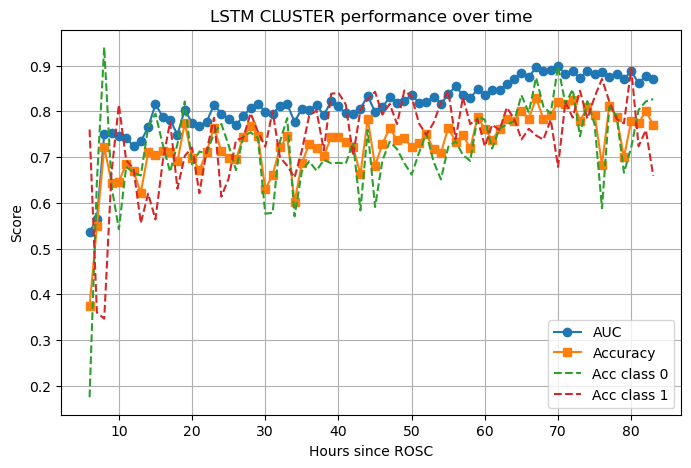

Run on cuda


Time points: 100%|█████████████████████████████████████████████████████████████████████| 78/78 [12:35<00:00,  9.69s/it]

Metrics saved to cluster_mul_o.csv


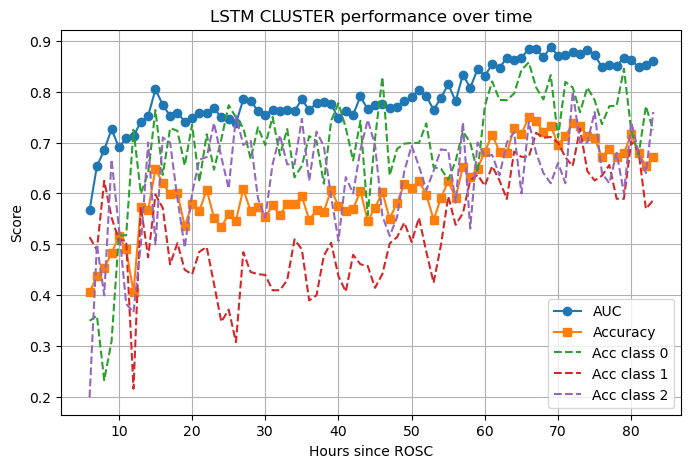

Run on cuda


Time points: 100%|█████████████████████████████████████████████████████████████████████| 78/78 [10:20<00:00,  7.96s/it]

Metrics saved to cpc_cli_o.csv


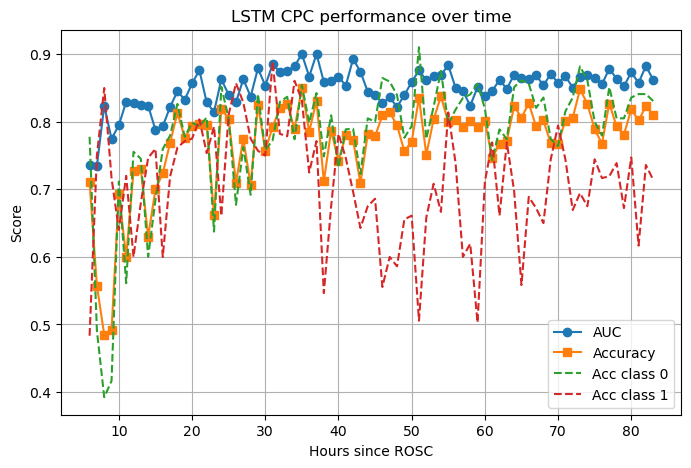

Run on cuda


Time points:  72%|█████████████████████████████████████████████████▌                   | 56/78 [06:58<03:11,  8.70s/it]

In [ ]:
config = {'hidden_size': 32, 'num_layers': 1, 'bidirectional': True, 'dropout': 0.2}
factory = make_model_factory(config)

run_task(
    path_csv="merged_all_features_clinical.csv",
    features=sorted_feats_km[:47],
    task='cluster',
    binary_labels=True,
    use_clinical=False,
    start=6,
    end=84,
    epochs=100,
    batch_size=64,
    out_csv='cluster_bi_o.csv',
    model_factory=factory   
)


config = {'hidden_size': 32, 'num_layers': 1, 'bidirectional': True, 'dropout': 0.2}
factory = make_model_factory(config)

run_task(
    path_csv="merged_all_features_clinical.csv",
    features=sorted_feats_km[:47],
    task='cluster',
    binary_labels=False,
    use_clinical=False,
    start=6,
    end=84,
    epochs=100,
    batch_size=64,
    out_csv='cluster_mul_o.csv',
    model_factory=factory    
)

config = {'hidden_size': 64, 'num_layers': 1, 'bidirectional': True, 'dropout': 0.5}
factory = make_model_factory(config)

run_task(
    path_csv="merged_all_features_clinical.csv",
    features=sorted_feats_cpc[:87],
    task='cpc',
    binary_labels=False,
    use_clinical=True,
    start=6,
    end=84,
    epochs=100,
    batch_size=64,
    out_csv='cpc_cli_o.csv',
    model_factory=factory    
)

config = {'hidden_size': 64, 'num_layers': 1, 'bidirectional': True, 'dropout': 0.5}
factory = make_model_factory(config)

run_task(
    path_csv="merged_all_features_clinical.csv",
    features=sorted_feats_cpc[:87],
    task='cpc',
    binary_labels=False,
    use_clinical=False,
    start=6,
    end=84,
    epochs=100,
    batch_size=64,
    out_csv='cpc_nocli_o.csv',
    model_factory=factory   
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_task_metrics(csv_path, task_name="Model"):
    df = pd.read_csv(csv_path)
    print(f"{task_name} metrics loaded from: {csv_path}")
    
    hours = df['hour']
    auc   = df['AUC']
    acc   = df['Accuracy']

    # 1. Plot the overall AUC curve (and Accuracy if uncommented)
    plt.figure(figsize=(8, 4))
    plt.plot(hours, auc, marker='o', label='AUC')
    # plt.plot(hours, acc, marker='s', label='Accuracy')
    plt.xlabel('Hours since ROSC')
    plt.ylabel('Score')
    plt.title(f'{task_name} AUC & Accuracy over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Plot per-class Accuracy curves if they exist
    class_cols = [col for col in df.columns if col.startswith('Acc_class_')]
    for col in class_cols:
        plt.figure(figsize=(6, 3))
        plt.plot(hours, df[col], marker='o')
        plt.xlabel('Hours since ROSC')
        plt.ylabel('Accuracy')
        plt.title(f'{col} over Time')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:
plot_task_metrics("cluster_bi_o.csv", task_name="Cluster (binary)")

In [ ]:
plot_task_metrics("cluster_mul_o.csv", task_name="Cluster (multiple)")

In [ ]:
plot_task_metrics("cpc_nocli_o.csv", task_name="CPC (no clin)")

In [ ]:
plot_task_metrics("cpc_cli_o.csv", task_name="CPC (clin)")